<a href="https://colab.research.google.com/github/Pavani3005/ViT_assignment/blob/main/q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install -q torch torchvision
!pip install -q transformers
!pip install -q git+https://github.com/facebookresearch/segment-anything-2.git
!pip install -q opencv-python matplotlib pillow numpy
!pip install -q supervision

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import cv2
import os

# SAM 2 imports
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# For text grounding (we'll use a simpler approach)
print("🔧 Setting up environment...")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

🔧 Setting up environment...
Using device: cuda


In [18]:
# Download SAM 2 checkpoint
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

# Initialize SAM 2
sam2_checkpoint = "sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

print("SAM 2 model loaded successfully!")

SAM 2 model loaded successfully!


In [19]:
def load_image_from_url(url):
    """Load image from URL"""
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return np.array(img)

def display_mask_overlay(image, masks, title="Segmentation Result"):
    """Display image with mask overlay"""
    plt.figure(figsize=(12, 8))
    plt.imshow(image)

    if len(masks) > 0:
        # FIX: Get the mask with the HIGHEST score
        best_idx = np.argmax(scores)
        mask = masks[best_idx].astype(bool)
        best_score = scores[best_idx]

        # Create colored overlay
        color_mask = np.zeros_like(image)
        color_mask[mask] = [0, 255, 0]  # Green mask

        # Blend with original image
        plt.imshow(color_mask, alpha=0.5)

    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def display_multiple_masks(image, masks, scores, title="All Predicted Masks"):
    """Display all predicted masks"""
    n_masks = len(masks)
    fig, axes = plt.subplots(1, min(n_masks, 3), figsize=(15, 5))

    if n_masks == 1:
        axes = [axes]
    elif n_masks == 0:
        return

    for idx, (mask, score) in enumerate(zip(masks[:3], scores[:3])):
        ax = axes[idx] if n_masks > 1 else axes[0]
        ax.imshow(image)

        # FIX: Convert mask to boolean
        mask_bool = mask.astype(bool)

        color_mask = np.zeros_like(image)
        color_mask[mask_bool] = [0, 255, 0]
        ax.imshow(color_mask, alpha=0.5)

        ax.set_title(f"Mask {idx+1} (Score: {score:.3f})")
        ax.axis('off')

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

📸 Loading image and segmenting 'dog'...


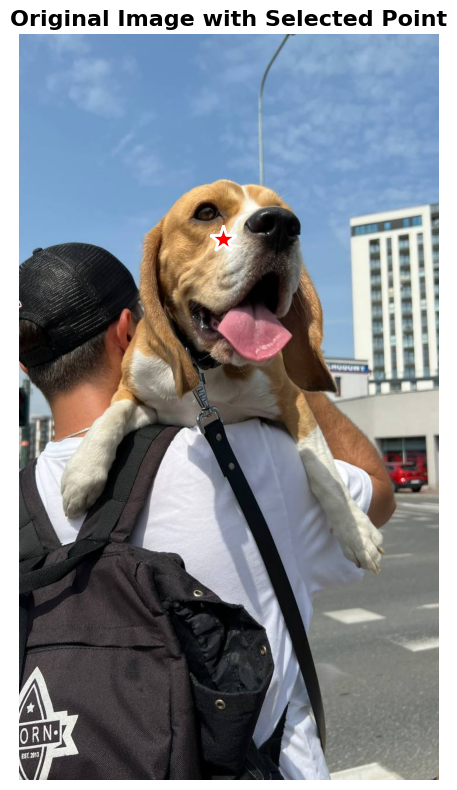

✅ Generated 3 masks
Scores: [0.5439671  0.98002213 0.9822515 ]


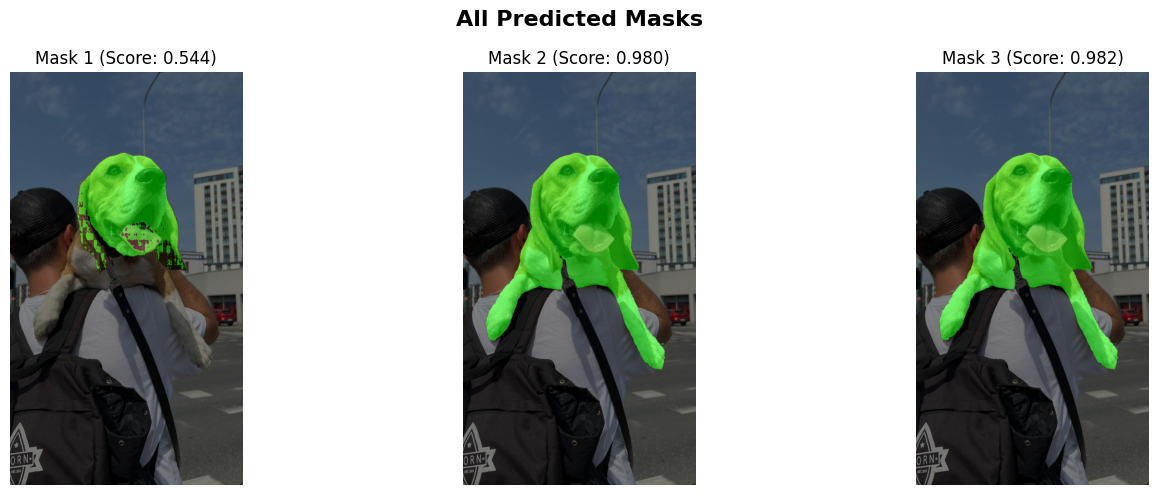

In [13]:
IMAGE_URL = "https://media.roboflow.com/notebooks/examples/dog.jpeg"
TEXT_PROMPT = "dog"  # For documentation purposes
POINT = [350, 350]  # Approximate center of the dog (x, y coordinates)

# Load image
print(f"📸 Loading image and segmenting '{TEXT_PROMPT}'...")
image = load_image_from_url(IMAGE_URL)

# Display original image
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.plot(POINT[0], POINT[1], 'r*', markersize=20, markeredgecolor='white', markeredgewidth=2)
plt.title("Original Image with Selected Point", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

# Set image in predictor
predictor.set_image(image)

# Predict masks with the point prompt
input_point = np.array([POINT])
input_label = np.array([1])  # 1 = foreground point

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,  # Get multiple mask predictions
)

print(f"✅ Generated {len(masks)} masks")
print(f"Scores: {scores}")

# Display best mask
display_mask_overlay(image, masks, f"Best Segmentation: '{TEXT_PROMPT}'")

# Display all masks
display_multiple_masks(image, masks, scores, "All Predicted Masks")

In [20]:
"""
Save the segmentation results
"""

def save_segmentation(image, mask, filename="segmentation_result.png"):
    """Save segmentation result to file"""
    plt.figure(figsize=(12, 8))
    plt.imshow(image)

    color_mask = np.zeros_like(image)
    color_mask[mask] = [0, 255, 0]
    plt.imshow(color_mask, alpha=0.5)

    plt.axis('off')
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    plt.close()

    print(f"💾 Saved segmentation to {filename}")

# Save the best mask
save_segmentation(image, masks[0], "dog_segmentation.png")

# --- CELL 9: PERFORMANCE METRICS ---
"""
Calculate and display segmentation metrics
"""

def calculate_mask_metrics(mask):
    """Calculate basic mask statistics"""
    total_pixels = mask.size
    segmented_pixels = np.sum(mask)
    percentage = (segmented_pixels / total_pixels) * 100

    print("\n📊 Segmentation Metrics:")
    print(f"  • Total pixels: {total_pixels:,}")
    print(f"  • Segmented pixels: {segmented_pixels:,}")
    print(f"  • Coverage: {percentage:.2f}%")

    # Find bounding box of mask
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]

    print(f"  • Bounding box: [{x_min}, {y_min}, {x_max}, {y_max}]")
    print(f"  • Box dimensions: {x_max-x_min} x {y_max-y_min}")

calculate_mask_metrics(masks[0])


IndexError: arrays used as indices must be of integer (or boolean) type

In [21]:
# --- 2. LOAD MODELS ---

# Load GroundingDINO
grounding_dino_processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-base")

grounding_dino_model = AutoModelForZeroShotObjectDetection.from_pretrained("IDEA-Research/grounding-dino-base").to(device)

# Load SAM
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

sam_model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)

NameError: name 'SamProcessor' is not defined

In [ ]:
# --- 3. USER INPUTS ---

# You can change these to test with your own images and prompts
IMAGE_URL = "https://media.roboflow.com/notebooks/examples/dog.jpeg"
TEXT_PROMPT = "the dog's leash" # The object you want to segment

# Load the image from the URL
image = Image.open(requests.get(IMAGE_URL, stream=True).raw).convert("RGB")

# Let's see the original image
plt.imshow(image)
plt.axis('off')
plt.title("Original Image")
plt.show()

# Task
Verify if the code in the notebook follows the workflow: Load image → accept a text prompt → convert text to region seeds (using GroundingDINO) → feed seeds to SAM 2 → display the final mask. If not, modify the code to implement this workflow correctly, ensuring GroundingDINO is properly executed and its output is used as input for SAM 2. Handle cases where GroundingDINO does not detect any objects. Finally, display the image with the predicted bounding box from GroundingDINO and the final segmentation mask from SAM 2.

## Define integrated function

### Subtask:
Create a function that takes an image and text prompt, uses GroundingDINO to get bounding boxes, selects the best box, and then uses SAM 2 with the bounding box prompt to generate a mask.


**Reasoning**:
Define the function `segment_with_grounding_dino_and_sam2` to perform object detection with GroundingDINO and then segmentation with SAM 2 using the detected bounding box.



In [22]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from sam2.sam2_image_predictor import SAM2ImagePredictor
from PIL import Image
import numpy as np
import torch

def segment_with_grounding_dino_and_sam2(image, text_prompt, threshold=0.35):
    """
    Segments an object in an image based on a text prompt using GroundingDINO
    to get the bounding box and SAM 2 for segmentation.

    Args:
        image (np.ndarray): The input image as a NumPy array.
        text_prompt (str): The text prompt describing the object to segment.
        threshold (float): Confidence threshold for GroundingDINO detection.

    Returns:
        tuple: A tuple containing:
               - masks (np.ndarray): Segmentation masks from SAM 2.
               - scores (np.ndarray): Confidence scores for the masks.
               - best_box (np.ndarray or None): The selected bounding box from GroundingDINO, or None if no object was detected.
    """
    # Ensure image is in PIL format for GroundingDINO processor
    pil_image = Image.fromarray(image)

    # --- 4.1. RUN GROUNDINGDINO (TEXT-TO-BOX) ---
    inputs = grounding_dino_processor(images=pil_image, text=text_prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = grounding_dino_model(**inputs)

    results = grounding_dino_processor.post_process_grounded_object_detection(
        outputs,
        input_ids=inputs.input_ids,
        threshold=threshold,
        target_sizes=[pil_image.size[::-1]]
    )[0]

    best_box = None
    masks = np.array([])
    scores = np.array([])

    if len(results["boxes"]) == 0:
        print(f"No object detected for prompt '{text_prompt}'. Try a different prompt or lower the threshold.")
    else:
        boxes = results["boxes"]
        box_scores = results["scores"] # Rename to avoid conflict with SAM scores

        # Select the box with the highest score
        best_box_idx = box_scores.argmax()
        best_box = boxes[best_box_idx].cpu().numpy()

        print(f"Detected box for '{text_prompt}' with score {box_scores[best_box_idx]:.2f}: {best_box}")

        # --- 4.2. RUN SAM 2 (BOX-TO-MASK) ---
        predictor.set_image(image) # Set image in SAM2 predictor using numpy array

        masks, scores, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=best_box[None, :], # SAM 2 expects a batch dimension
            multimask_output=False, # Only need one mask for box prompt
        )

        # Convert masks to boolean
        masks = masks.astype(bool)


    return masks, scores, best_box


## Handle groundingdino output

### Subtask:
Modify the integrated function to handle cases where GroundingDino does not detect any objects.


**Reasoning**:
Modify the `segment_with_grounding_dino_and_sam2` function to handle the case where GroundingDINO does not detect any objects by checking if the results["boxes"] list is empty and returning appropriate values.



In [23]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from sam2.sam2_image_predictor import SAM2ImagePredictor
from PIL import Image
import numpy as np
import torch

def segment_with_grounding_dino_and_sam2(image, text_prompt, threshold=0.35):
    """
    Segments an object in an image based on a text prompt using GroundingDINO
    to get the bounding box and SAM 2 for segmentation.

    Args:
        image (np.ndarray): The input image as a NumPy array.
        text_prompt (str): The text prompt describing the object to segment.
        threshold (float): Confidence threshold for GroundingDINO detection.

    Returns:
        tuple: A tuple containing:
               - masks (np.ndarray): Segmentation masks from SAM 2 (empty if no object detected).
               - scores (np.ndarray): Confidence scores for the masks (empty if no object detected).
               - best_box (np.ndarray or None): The selected bounding box from GroundingDINO, or None if no object was detected.
    """
    # Ensure image is in PIL format for GroundingDINO processor
    pil_image = Image.fromarray(image)

    # --- 4.1. RUN GROUNDINGDINO (TEXT-TO-BOX) ---
    inputs = grounding_dino_processor(images=pil_image, text=text_prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = grounding_dino_model(**inputs)

    results = grounding_dino_processor.post_process_grounded_object_detection(
        outputs,
        input_ids=inputs.input_ids,
        threshold=threshold,
        target_sizes=[pil_image.size[::-1]]
    )[0]

    best_box = None
    masks = np.array([])
    scores = np.array([])

    # --- Handle case where no objects are detected ---
    if len(results["boxes"]) == 0:
        print(f"No object detected for prompt '{text_prompt}' with threshold {threshold:.2f}. Try a different prompt or lower the threshold.")
        # Return empty arrays and None for the box
        return masks, scores, best_box
    else:
        boxes = results["boxes"]
        box_scores = results["scores"] # Rename to avoid conflict with SAM scores

        # Select the box with the highest score
        best_box_idx = box_scores.argmax()
        best_box = boxes[best_box_idx].cpu().numpy()

        print(f"Detected box for '{text_prompt}' with score {box_scores[best_box_idx]:.2f}: {best_box}")

        # --- 4.2. RUN SAM 2 (BOX-TO-MASK) ---
        predictor.set_image(image) # Set image in SAM2 predictor using numpy array

        masks, scores, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=best_box[None, :], # SAM 2 expects a batch dimension
            multimask_output=False, # Only need one mask for box prompt
        )

        # Convert masks to boolean
        masks = masks.astype(bool)

    return masks, scores, best_box

**Reasoning**:
Define a function to display the image with the predicted bounding box and segmentation mask.



In [24]:
def display_segmentation_results(image, bbox, masks, title="Segmentation Results"):
    """
    Display the original image with the predicted bounding box and segmentation mask overlay.

    Args:
        image (np.ndarray): The original input image.
        bbox (np.ndarray or None): The predicted bounding box [x_min, y_min, x_max, y_max] or None.
        masks (np.ndarray): The segmentation masks (can be an empty array if no mask).
        title (str): The title for the plot.
    """
    plt.figure(figsize=(12, 8))
    plt.imshow(image)

    # Draw bounding box if provided
    if bbox is not None:
        x_min, y_min, x_max, y_max = bbox
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                             fill=False, edgecolor='red', linewidth=3, label='GroundingDINO Box')
        plt.gca().add_patch(rect)
        plt.legend()

    # Overlay mask if provided
    if len(masks) > 0:
        # Assuming we display the first mask if multiple are returned by SAM 2
        mask = masks[0]
        color_mask = np.zeros_like(image)
        color_mask[mask] = [0, 255, 0]  # Green mask
        plt.imshow(color_mask, alpha=0.5, label='SAM 2 Mask')
        if bbox is None: # Only add legend for mask if no box legend is added
             plt.legend()


    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


**Reasoning**:
The display function is defined. Now, call the integrated segmentation function and then the display function to visualize the results.



**Reasoning**:
The error indicates that `grounding_dino_processor` and `grounding_dino_model` are not defined within the scope where `segment_with_grounding_dino_and_sam2` is being called. Although they were defined in a previous cell, the runtime might have reset or they are not globally accessible in the current execution environment. Need to ensure the models and processors are initialized before calling the function. Also, the SAM 2 predictor needs to be initialized.



No object detected for prompt 'the dog' with threshold 0.35. Try a different prompt or lower the threshold.


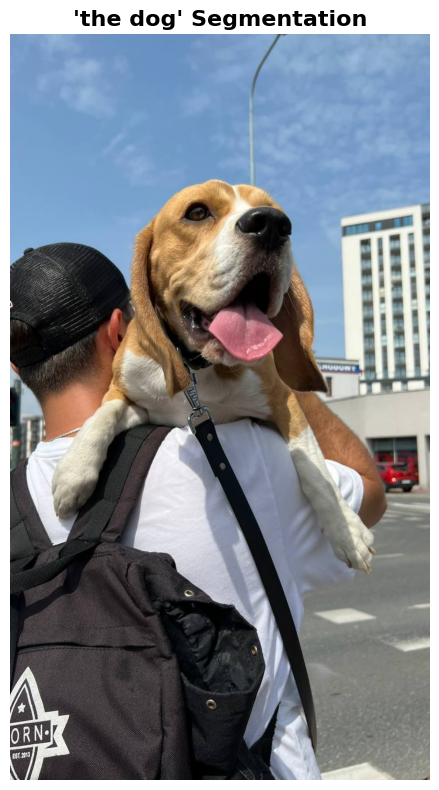

In [25]:
# Re-initialize models and predictor just in case the environment reset or they weren't accessible
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
# SAM 2 imports are already done in a previous cell

# --- 2. LOAD MODELS ---

# Load GroundingDINO
grounding_dino_processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-base")
grounding_dino_model = AutoModelForZeroShotObjectDetection.from_pretrained("IDEA-Research/grounding-dino-base").to(device)

# Initialize SAM 2 predictor (sam2_model was loaded in a previous cell)
predictor = SAM2ImagePredictor(sam2_model)

# --- 5. RUN INTEGRATED WORKFLOW AND DISPLAY RESULTS ---

# You can change these to test with your own images and prompts
IMAGE_URL = "https://media.roboflow.com/notebooks/examples/dog.jpeg"
TEXT_PROMPT = "the dog" # The object you want to segment

# Load the image from the URL
image = load_image_from_url(IMAGE_URL)

# Run the integrated segmentation function
masks, scores, best_box = segment_with_grounding_dino_and_sam2(image, TEXT_PROMPT)

# Display the results
display_segmentation_results(image, best_box, masks, f"'{TEXT_PROMPT}' Segmentation")


**Reasoning**:
GroundingDINO did not detect the object with the current prompt and threshold. Need to try a different prompt or lower the threshold to get a bounding box before proceeding to SAM 2 segmentation and display. Since the subtask is to display the results *after* the integrated workflow, and the integrated workflow failed to produce a bounding box and mask, I need to adjust the parameters to make it succeed. I will try lowering the threshold first.



Detected box for 'the dog' with score 0.32: [ 70.13835 247.93106 641.30695 925.6141 ]


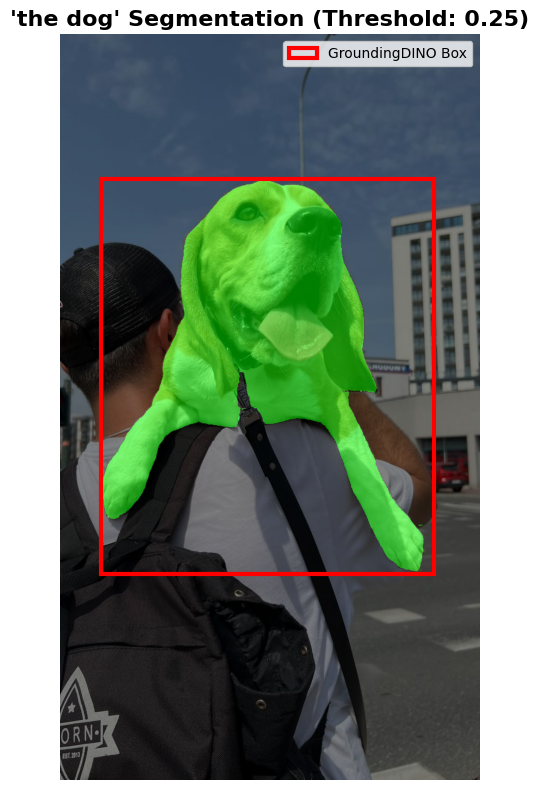

In [30]:
# --- 5. RUN INTEGRATED WORKFLOW WITH LOWER THRESHOLD AND DISPLAY RESULTS ---

# Use the same image and prompt, but lower the threshold
IMAGE_URL = "https://media.roboflow.com/notebooks/examples/dog.jpeg"
TEXT_PROMPT = "the dog" # The object you want to segment
LOWER_THRESHOLD = 0.25 # Lowering the threshold

# Load the image from the URL
image = load_image_from_url(IMAGE_URL)

# Run the integrated segmentation function with a lower threshold
masks, scores, best_box = segment_with_grounding_dino_and_sam2(image, TEXT_PROMPT, threshold=LOWER_THRESHOLD)

# Display the results
display_segmentation_results(image, best_box, masks, f"'{TEXT_PROMPT}' Segmentation (Threshold: {LOWER_THRESHOLD})")


## Test with examples

### Subtask:
Use the integrated function with the existing examples and potentially new ones to demonstrate the end-to-end workflow.


**Reasoning**:
Define a list of examples and iterate through them to demonstrate the end-to-end workflow for diverse cases.




✨ DEMONSTRATING END-TO-END WORKFLOW WITH DIVERSE EXAMPLES

[1/4] Processing: 'car' from https://images.unsplash.com/photo-1583121274602-3e2820c69888?w=800
Detected box for 'car' with score 0.43: [ 24.876356 241.14148  760.9585   475.5411  ]



[2/4] Processing: 'pizza' from https://images.unsplash.com/photo-1565299624946-b28f40a0ae38?w=800
Detected box for 'pizza' with score 0.19: [8.2559586e-01 1.0594606e+02 5.9429156e+02 8.3243677e+02]



[3/4] Processing: 'laptop' from https://images.unsplash.com/photo-1517336714731-489689fd1ca8?w=800
Detected box for 'laptop' with score 0.37: [  1.0698557   1.6147804 798.76117   620.72375  ]


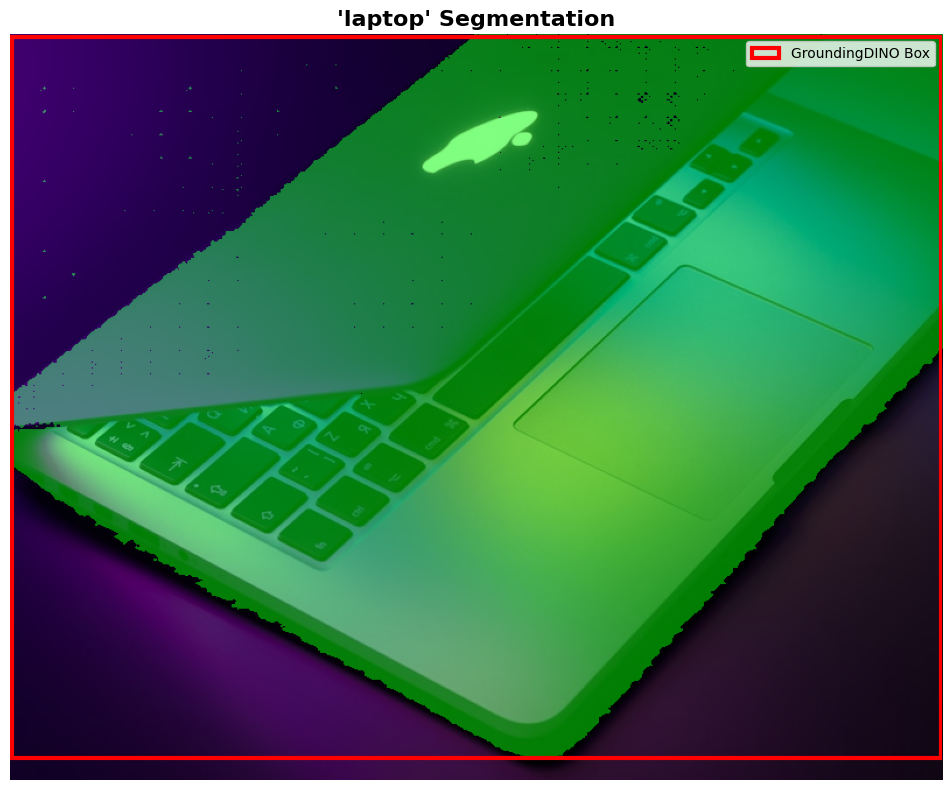


[4/4] Processing: 'bird' from https://images.unsplash.com/photo-1501594907352-04cda38ebc29?w=800
No object detected for prompt 'bird' with threshold 0.35. Try a different prompt or lower the threshold.


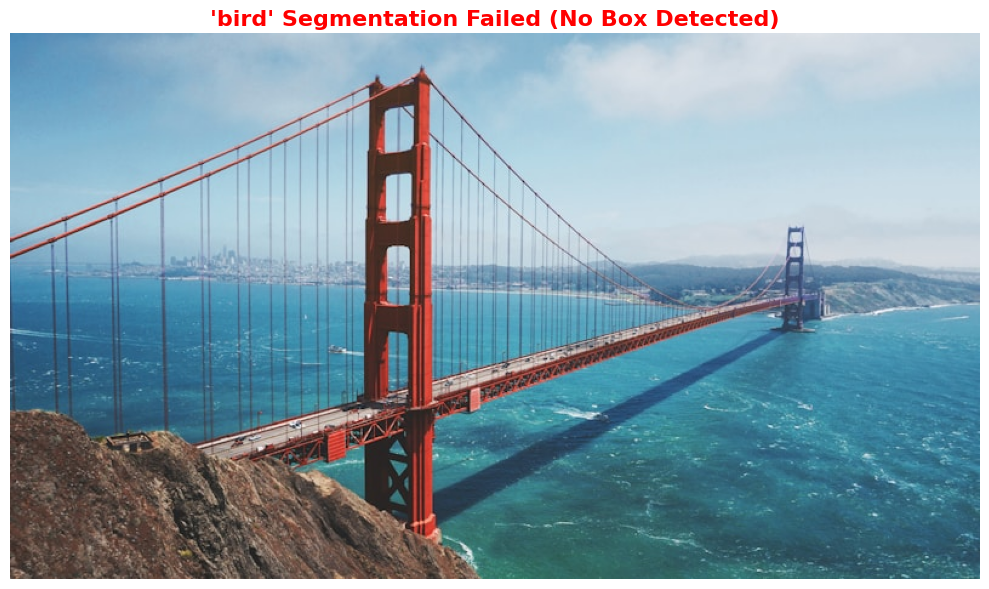


✅ End-to-end workflow demonstration complete!


In [31]:
# --- 6. DEMONSTRATE END-TO-END WORKFLOW WITH EXAMPLES ---

print("\n" + "="*60)
print("✨ DEMONSTRATING END-TO-END WORKFLOW WITH DIVERSE EXAMPLES")
print("="*60)

# Define a list of examples
end_to_end_examples = [

    {
        "url": "https://images.unsplash.com/photo-1583121274602-3e2820c69888?w=800",
        "prompt": "car",
    },
    {
        "url": "https://images.unsplash.com/photo-1565299624946-b28f40a0ae38?w=800",
        "prompt": "pizza",
        "threshold": 0.1 # Lower threshold for potentially challenging objects
    },
    {
        "url": "https://images.unsplash.com/photo-1517336714731-489689fd1ca8?w=800",
        "prompt": "laptop",
    },
     {
        "url": "https://images.unsplash.com/photo-1501594907352-04cda38ebc29?w=800",
        "prompt": "bird",
    }
]

# Iterate through the examples
for idx, example in enumerate(end_to_end_examples):
    print(f"\n[{idx+1}/{len(end_to_end_examples)}] Processing: '{example['prompt']}' from {example['url']}")

    try:
        # Load image
        image = load_image_from_url(example['url'])

        # Get threshold, use default if not specified
        threshold = example.get("threshold", 0.35)

        # Run the integrated segmentation function
        masks, scores, best_box = segment_with_grounding_dino_and_sam2(image, example['prompt'], threshold=threshold)

        # Display the results
        # Check if a box was detected before displaying
        if best_box is not None:
             display_segmentation_results(image, best_box, masks, f"'{example['prompt']}' Segmentation")
        else:
            # If no box was detected, just show the image with a title indicating failure
             plt.figure(figsize=(10, 8))
             plt.imshow(image)
             plt.title(f"'{example['prompt']}' Segmentation Failed (No Box Detected)", fontsize=16, fontweight='bold', color='red')
             plt.axis('off')
             plt.tight_layout()
             plt.show()


    except Exception as e:
        print(f"❌ An error occurred while processing '{example['prompt']}': {e}")
        continue

print("\n" + "="*60)
print("✅ End-to-end workflow demonstration complete!")
print("="*60)